<img src="https://gitlab.com/bivl2ab/academico/macv/semillero-uis-2020-2/-/raw/master/img/Banner_Logo.jpeg" alt="Drawing" style="width:700px;">

**connect google colab and google drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
import pandas as pd
import numpy as np
import imageio
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from skimage.transform import resize
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay 

# <font color='red'>**Loading train dataset**</font>


In [5]:
train_path = "/content/drive/MyDrive/semillero Bivl2ab 2021-1/data/csv files/train.csv"
train_df = pd.read_csv(train_path, header=None)
train_df.head()

0             1
0  /content/drive/MyDrive/semillero Bivl2ab 2021-...  hiperplastic
1  /content/drive/MyDrive/semillero Bivl2ab 2021-...  hiperplastic
2  /content/drive/MyDrive/semillero Bivl2ab 2021-...  hiperplastic
3  /content/drive/MyDrive/semillero Bivl2ab 2021-...  hiperplastic
4  /content/drive/MyDrive/semillero Bivl2ab 2021-...  hiperplastic

In [6]:
train_df.columns = ['path', 'label']
train_df.head()

path         label
0  /content/drive/MyDrive/semillero Bivl2ab 2021-...  hiperplastic
1  /content/drive/MyDrive/semillero Bivl2ab 2021-...  hiperplastic
2  /content/drive/MyDrive/semillero Bivl2ab 2021-...  hiperplastic
3  /content/drive/MyDrive/semillero Bivl2ab 2021-...  hiperplastic
4  /content/drive/MyDrive/semillero Bivl2ab 2021-...  hiperplastic

In [7]:
train_ade = train_df.loc[train_df['label'] == 'adenoma'][0:333]
train_hip = train_df.loc[train_df['label'] == 'hiperplastic'][0:333]
train_ser = train_df.loc[train_df['label'] == 'serrated'][0:333]
train_2 = pd.concat([train_ade, train_hip, train_ser], axis=0)
train_2.head()

path    label
2624  /content/drive/MyDrive/semillero Bivl2ab 2021-...  adenoma
2625  /content/drive/MyDrive/semillero Bivl2ab 2021-...  adenoma
2626  /content/drive/MyDrive/semillero Bivl2ab 2021-...  adenoma
2627  /content/drive/MyDrive/semillero Bivl2ab 2021-...  adenoma
2628  /content/drive/MyDrive/semillero Bivl2ab 2021-...  adenoma

In [8]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255., 
                                                          validation_split=0.1, 
                                                          rotation_range=40,
                                                          horizontal_flip=True,
                                                          fill_mode='reflect')

In [9]:
visual_generator = datagen.flow_from_dataframe(
    train_2,
    directory=None,
    subset = "training",
    x_col="path",
    y_col="label",
    batch_size=1,
    shuffle=True,
    target_size=(32,32)
)

Found 900 validated image filenames belonging to 3 classes.


In [10]:
labels={0: 'adenoma',
        1: 'hiperplastic',
        2: 'serrated'}

In [11]:
train_generator = datagen.flow_from_dataframe(
    train_2,
    directory=None,
    subset = "training",
    x_col="path",
    y_col="label",
    batch_size=16,
    shuffle=True,
    target_size=(32,32)
)

valid_generator = datagen.flow_from_dataframe(
    train_2,
    directory=None,
    subset = "validation",
    x_col="path",
    y_col="label",
    batch_size=16,
    shuffle=True,
    target_size=(32,32)    
)

Found 900 validated image filenames belonging to 3 classes.
Found 99 validated image filenames belonging to 3 classes.


#<font color='red'>**Fortunately**</font>

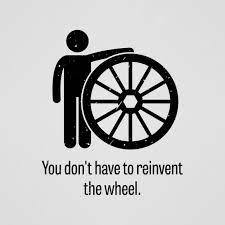

In [12]:
my_vgg16 = tf.keras.applications.VGG16(include_top=False, weights='imagenet')

58900480/58889256 [==============================] - 1s 0us/step


In [13]:
my_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [18]:
input = layers.Input(shape=(32,32,3))
output_vgg16 = my_vgg16(input)

x = layers.Flatten()(output_vgg16)
x = layers.Dense(units=1024, activation='relu')(x)
x = layers.Dense(units=512, activation='relu')(x)
x = layers.Dense(units=3, activation='softmax')(x) 
my_cnn2 = keras.Model(input, x)

In [19]:
my_cnn2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 1539      
Total params: 15,766,339
Trainable params: 15,766,339
Non-trainable params: 0
_________________________________________________

**Let's train it!**

In [20]:
opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
my_cnn2.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
history = my_cnn2.fit(train_generator, validation_data = valid_generator, epochs=10)

Epoch 1/10
57/57 [==============================] - 304s 5s/step - loss: 0.6465 - accuracy: 0.7533 - val_loss: 1.1058 - val_accuracy: 0.3535
Epoch 2/10
57/57 [==============================] - 13s 231ms/step - loss: 0.2705 - accuracy: 0.9167 - val_loss: 0.1842 - val_accuracy: 0.9394
Epoch 3/10
57/57 [==============================] - 13s 231ms/step - loss: 0.2109 - accuracy: 0.9244 - val_loss: 0.6644 - val_accuracy: 0.7576
Epoch 4/10
57/57 [==============================] - 13s 233ms/step - loss: 0.1101 - accuracy: 0.9689 - val_loss: 1.3431 - val_accuracy: 0.6970
Epoch 5/10
57/57 [==============================] - 13s 233ms/step - loss: 0.1056 - accuracy: 0.9633 - val_loss: 0.9793 - val_accuracy: 0.7071
Epoch 6/10
57/57 [==============================] - 13s 230ms/step - loss: 0.0437 - accuracy: 0.9844 - val_loss: 0.4090 - val_accuracy: 0.8586
Epoch 7/10
57/57 [==============================] - 13s 233ms/step - loss: 0.0431 - accuracy: 0.9878 - val_loss: 0.1798 - val_accuracy: 0.9495
E

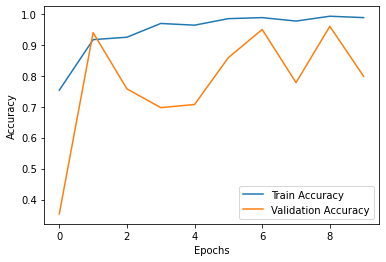

In [22]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

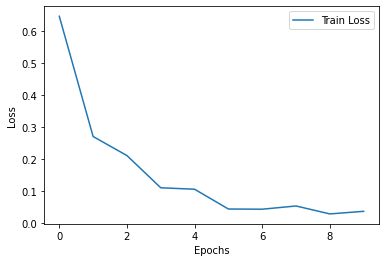

In [23]:
plt.plot(history.history['loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#<font color='red'>**Let's test it!**</font>

**Loading test dataset...**

In [24]:
test_path = "/content/drive/MyDrive/semillero Bivl2ab 2021-1/data/csv files/test.csv"
test_df = pd.read_csv(test_path, header=None)
test_df.columns = ['path', 'label']
test_df.head()

path         label
0  /content/drive/MyDrive/semillero Bivl2ab 2021-...  hiperplastic
1  /content/drive/MyDrive/semillero Bivl2ab 2021-...  hiperplastic
2  /content/drive/MyDrive/semillero Bivl2ab 2021-...  hiperplastic
3  /content/drive/MyDrive/semillero Bivl2ab 2021-...  hiperplastic
4  /content/drive/MyDrive/semillero Bivl2ab 2021-...  hiperplastic

In [25]:
test_ade = test_df.loc[test_df['label'] == 'adenoma'][0:100]
test_hip = test_df.loc[test_df['label'] == 'hiperplastic'][0:100]
test_ser = test_df.loc[test_df['label'] == 'serrated'][0:100]
test_2 = pd.concat([test_ade, test_hip, test_ser], axis=0)
test_2 = test_2.reset_index(drop=True)

In [26]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [27]:
test_generator = datagen.flow_from_dataframe(
    test_2,
    directory=None,
    x_col="path",
    y_col="label",
    batch_size=8,
    shuffle=True,
    target_size=(32,32)
)

Found 300 validated image filenames belonging to 3 classes.


In [28]:
def model_evaluate(model, generator):
  test_loss, test_acc = model.evaluate(generator)
  print('Test accuracy:', test_acc)

In [30]:
model_evaluate(my_cnn2,test_generator)

38/38 [==============================] - 80s 2s/step - loss: 3.1800 - accuracy: 0.3967
Test accuracy: 0.39666667580604553


In [32]:
predictions = my_cnn2.predict(test_generator)
print("predictions shape: ", predictions.shape)

predictions shape:  (300, 3)


**predicting one image...**

leyendo de:  /content/drive/MyDrive/semillero Bivl2ab 2021-1/data/images/test/hiperplastic/hiperplastic_NBI_video_11_img_73.png


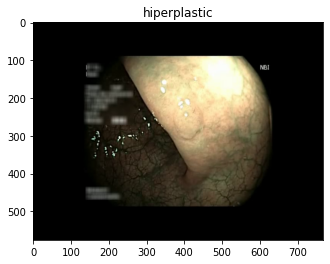

In [33]:
idx = 100
path_img = test_2['path'][idx]
print("leyendo de: ", path_img)
img = imageio.imread(path_img)
plt.title(test_df['label'][idx])
plt.imshow(img)

In [37]:
img = resize(img,((1,32,32,3)))
probs = my_cnn2.predict(img)
print("pred: {} conf: {}".format(labels[np.argmax(probs)],"%0.2f"%np.max(probs)))

pred: hiperplastic conf: 0.99


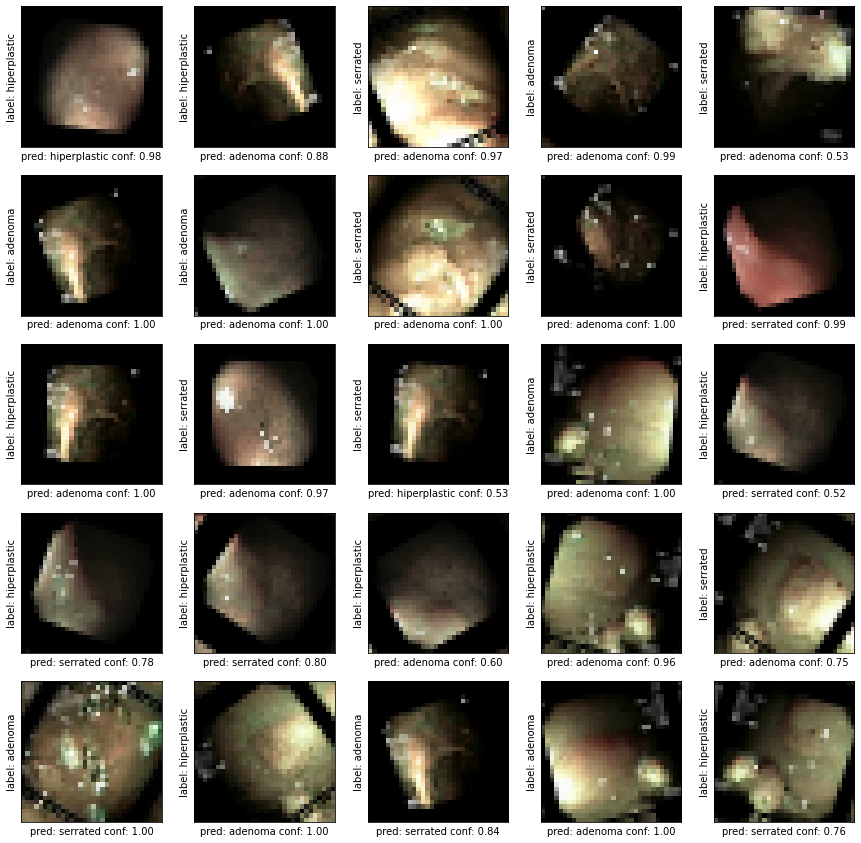

In [38]:
plt.figure(figsize=(15,15))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(np.squeeze(next(visual_generator)[0]))#convert (batch, high, width, #channels) into (high, width, #channels) 
  plt.xlabel("pred: {} conf: {}".format(labels[np.argmax(predictions[i])],"%0.2f"%np.max(predictions[i])))
  plt.ylabel("label: {}".format(labels[np.argmax(next(visual_generator)[1])]))

#<font color='red'>**Some qualitative results**</font>

In [42]:
logits = my_cnn2.predict(test_generator, test_generator.batch_size)
y_pred_class = np.argmax(logits, axis=1)
predicted_class_probab=np.max(logits,axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred_class))
print('Classification Report')
target_names = ['Adenoma', 'Hyperplastic', 'Serrated']    
print(classification_report(test_generator.classes, y_pred_class, target_names=target_names))

Confusion Matrix
[[68  8 24]
 [65 13 22]
 [73  8 19]]
Classification Report
              precision    recall  f1-score   support

     Adenoma       0.33      0.68      0.44       100
Hyperplastic       0.45      0.13      0.20       100
    Serrated       0.29      0.19      0.23       100

    accuracy                           0.33       300
   macro avg       0.36      0.33      0.29       300
weighted avg       0.36      0.33      0.29       300



<font color='purple'>**Student challenge**</font>
Try different architectures available

## Referencias

[1.] Set of available models tensorflow: https://www.tensorflow.org/api_docs/python/tf/keras/applications

[2.] About metrics: https://medium.com/analytics-vidhya/confusion-matrix-accuracy-precision-recall-f1-score-ade299cf63cd

<img src="https://gitlab.com/bivl2ab/academico/macv/semillero-uis-2020-2/-/raw/master/img/thanks.jpg" style="width:700px;">

